In this notebook we take the Illustris-1 simulation volume to find Local Group candidates.

These candidates have the following characteristics:

1. They are composed by two dark matter halos, $H_A$ and $H_B$.
2. $H_A$ and $H_B$ belong to the set of dark matter halos $S_{1}$; $S_{1}$ contains all the halos in the mass range $5\times 10^{11}$ M$_{\odot}<M_h < 5\times 10^{12}$ M$_{\odot}$
3. The distance between $H_A$ and $H_B$ is less than 1.3 Mpc.
4. The relative physical velocity (i.e. taking into account the hubble flow) is less than $150 \mathrm{km/s}$
5. $H_A$ and $H_B$ are mutually its nearest halos in the set $S_{1}$.
6. There are not any halos more massive than $5\times 10^{12} $ M$_{\odot}$ within $5 \mathrm{Mpc}$ of either $H_A$ or $H_B$.
7. There are not any halos more massive than $1\times 10^{14} $ M$_{\odot}$ within $12 \mathrm{Mpc}$ of either $H_A$ or $H_B$.

We now proceed to build such sample.

In [296]:
%pylab inline
import illustris_python as il
from sklearn.neighbors import NearestNeighbors

Populating the interactive namespace from numpy and matplotlib


In [297]:
basePath = '/home/forero/work/data/Illustris/illustris-1/' #change it accordingly to the path to the data

In [298]:
halos = il.groupcat.loadHalos(basePath,135) # the selection is based on the FOF groups
header = il.groupcat.loadHeader(basePath,135)

In [299]:
hubble = 0.7
BoxSize = header['BoxSize']/hubble

In [300]:
halo_M_crit200 = halos['Group_M_Crit200']/hubble # the mass selection is based on this halo mass definition

In [301]:
#selects the indices for the two sets above mentioned
index_S1 = where((halo_M_crit200>50.0) & (halo_M_crit200<=500.0))
index_S2 = where((halo_M_crit200>500)) 
index_S3 = where((halo_M_crit200>50.0))#this is an intermediary set to make the sample selection easier
index_S1 = index_S1[0]
index_S2 = index_S2[0]
index_S3 = index_S3[0]
n_S1 = size(index_S1)
n_S2 = size(index_S2)
n_S3 = size(index_S3)
print("size set S1: %d halos"%(n_S1))
print("size set S2: %d halos"%(n_S2))
print("size set S3: %d halos"%(n_S3))

size set S1: 2661 halos
size set S2: 275 halos
size set S3: 2936 halos


In [302]:
S3_pos = halos['GroupPos'][index_S3]/hubble
S3_vel = halos['GroupVel'][index_S3]/hubble
S3_mass = halos['Group_M_Mean200'][index_S3]/hubble

In [303]:
#pad boxes around the S3 positions to mimic periodic boundary conditions
S3_pad_pos = S3_pos.copy()
S3_pad_vel = S3_vel.copy()
S3_pad_mass = S3_mass.copy()
S3_pad_id = arange(n_S3)
for i in (0,1,-1):
    for j in (0,1,-1):
        for k in (0,1,-1):
            new_pos = S3_pos.copy()
            if(i):
                new_pos[:,0] = new_pos[:,0] + i*BoxSize
            if(j):
                new_pos[:,1] = new_pos[:,1] + j*BoxSize
            if(k):
                new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
            if((i!=0) | (j!=0) | (k!=0)):
                S3_pad_pos = append(S3_pad_pos, new_pos, axis=0)
                S3_pad_vel = append(S3_pad_vel, S3_vel, axis=0)
                S3_pad_mass = append(S3_pad_mass, S3_mass, axis=0)
                S3_pad_ID = append(S3_pad_id, arange(n_S3))

In [304]:
nbrs_S3 = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(S3_pad_pos)
dist_S3, ind_S3 = nbrs_S3.kneighbors(S3_pad_pos)
print S3_pad_pos.shape
print dist_S3.shape

(79272, 3)
(79272, 20)


In [330]:
neighbor_index = ind_S3[:,1]
neighbor_list = ind_S3[:,2:]
print shape(neighbor_list)

n_pairs = 0

halo_A_id = empty((0), dtype=int)
halo_B_id = empty((0), dtype=int)

for i in range(n_S3):
    l = neighbor_index[neighbor_index[i]]% n_S3
    j = neighbor_index[i] % n_S3
    
    other_j = neighbor_list[i,:] % n_S3
    other_l = neighbor_list[neighbor_index[i],:] % n_S3
    
    if((i==l) & (not (j in halo_A_id)) & (not (j in halo_B_id))): # first check to find mutual neighbors
        
        if((S3_mass[i]<=500.0) & (S3_mass[j]<=500.0)): #second check on the masses of the two halos
            
            if(dist_S3[i,1]<(1300.0)): #third check on the distance between the two halos
  
                relative_vel = sqrt(sum((S3_pad_vel[i,:] - S3_pad_vel[j, :] + (hubble*100*dist_S3[i,1]/1000))**2))
                if(relative_vel<150.0): #check on the relative velocity
    
                    massive_close_to_i = any((dist_S3[i,2:]<(5000.0)) & (S3_mass[other_j]>=500.0))
                    massive_close_to_j = any((dist_S3[j,2:]<(5000.0)) & (S3_mass[other_l]>=500.0))
                    if((not massive_close_to_i) & (not massive_close_to_j)): #third check on isolation from massive halos
                
                        virgo_close_to_i = any((dist_S3[i,2:]<(12000.0)) & (S3_mass[other_j]>=1.0E4))
                        virgo_close_to_j = any((dist_S3[j,2:]<(12000.0)) & (S3_mass[other_l]>=1.0E4))
                        if((not virgo_close_to_i) & (not virgo_close_to_j)):
                            n_pairs = n_pairs+ 1
                            halo_A_id = append(halo_A_id, int(i))
                            halo_B_id = append(halo_B_id, int(j))
print n_pairs

(79272, 18)
44


In [333]:
relative_vel = S3_pad_vel[halo_A_id,:] - S3_pad_vel[neighbor_index[halo_A_id], :]
norm_relative_vel = sqrt((relative_vel**2).sum(1))

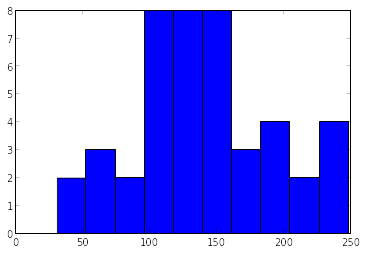

In [334]:
a = hist(norm_relative_vel)

In [335]:
relative_pos = S3_pad_pos[halo_A_id,:] - S3_pad_pos[neighbor_index[halo_A_id], :]
norm_relative_pos = sqrt((relative_pos**2).sum(1))

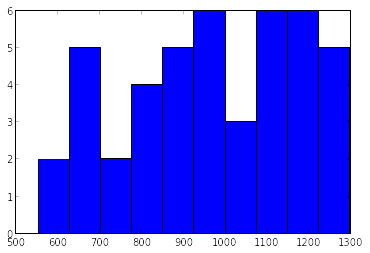

In [336]:
a = hist(norm_relative_pos)

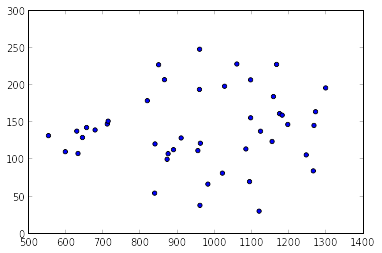

In [337]:
scatter(norm_relative_pos, norm_relative_vel)

In [338]:
center_of_mass = (S3_pad_pos[halo_A_id,:] * S3_pad_mass[halo_A_id].reshape(n_pairs,1)\
            + S3_pad_pos[neighbor_index[halo_A_id],:] * S3_pad_mass[neighbor_index[halo_A_id]].reshape(n_pairs,1))/\
            (S3_pad_mass[halo_A_id].reshape(n_pairs,1) + S3_pad_mass[neighbor_index[halo_A_id]].reshape(n_pairs,1))

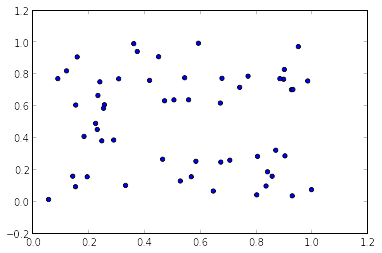

In [319]:
scatter(center_of_mass[:,0]/BoxSize, center_of_mass[:,1]/BoxSize)